# Analisis Clustering Data Banjir Provinsi 2023

## Deskripsi Project
Analisis ini menggunakan data banjir provinsi tahun 2023 untuk melakukan clustering menggunakan tiga metode berbeda:
1. **KMeans** - Partitioning-based clustering
2. **GMM (Gaussian Mixture Model)** - Probabilistic clustering
3. **DBSCAN** - Density-based clustering

Setiap metode akan dievaluasi dan dibandingkan untuk menemukan pola terbaik dalam data banjir provinsi.

## 1. Import Library

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Library berhasil dimuat!")

Library berhasil dimuat!


## 2. Load dan Eksplorasi Data

In [2]:
# Load data
file_path = r"F:\Semester 5\Pengantar Data Mining\Final Project\prov_banjir_2023.xlsx"
df = pd.read_excel(file_path)

print("Dataset berhasil dimuat!")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nBeberapa baris pertama:")
df.head()

Dataset berhasil dimuat!
Jumlah baris: 38
Jumlah kolom: 8

Beberapa baris pertama:


,province,banyak_terjadi_banjir,death,missing_person,injured_person,damaged_house,flooded_house,damaged_facility
0,ACEH,97,37,9,189,1689,57157,54
1,BALI,5,34,1,317,74,2410,13
2,BANTEN,28,11,2,59,541,7695,19
3,BENGKULU,11,12,1,119,29,8089,12
4,DAERAH ISTIMEWA YOGYAKARTA,6,51,1,253,894,847,79


In [3]:
# Informasi dataset
print("Informasi Dataset:")
print(df.info())
print("\n" + "="*50)
print("Statistik Deskriptif:")
df.describe()

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   province               38 non-null     object
 1   banyak_terjadi_banjir  38 non-null     int64 
 2   death                  38 non-null     int64 
 3   missing_person         38 non-null     int64 
 4   injured_person         38 non-null     int64 
 5   damaged_house          38 non-null     int64 
 6   flooded_house          38 non-null     int64 
 7   damaged_facility       38 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 2.5+ KB
None

Statistik Deskriptif:


,banyak_terjadi_banjir,death,missing_person,injured_person,damaged_house,flooded_house,damaged_facility
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,33.289474,32.578947,3.157895,355.578947,1242.473684,25456.842105,54.394737
std,32.400290,46.482564,4.090373,907.780829,2371.836758,32927.409795,92.160711
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.750000,9.500000,1.000000,37.000000,56.000000,3599.750000,2.250000
50%,22.500000,16.000000,2.000000,75.000000,525.000000,8568.000000,14.000000
75%,46.500000,36.250000,4.000000,249.000000,1268.250000,40894.500000,89.000000
max,112.000000,240.000000,20.000000,5359.000000,11298.000000,120542.000000,478.000000


In [4]:
# Cek missing values
print("Missing Values:")
missing_df = pd.DataFrame({
    'Kolom': df.columns,
    'Missing': df.isnull().sum(),
    'Persentase': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_df[missing_df['Missing'] > 0])

Missing Values:
Empty DataFrame
Columns: [Kolom, Missing, Persentase]
Index: []


## 2.1 Analisis Multikolinearitas

Sebelum melakukan clustering, penting untuk mengecek multikolinearitas antar fitur. Multikolinearitas terjadi ketika dua atau lebih fitur berkorelasi tinggi, yang dapat:
- Menyebabkan fitur tertentu mendominasi perhitungan jarak
- Mengurangi efektivitas clustering
- Membuat interpretasi hasil lebih sulit

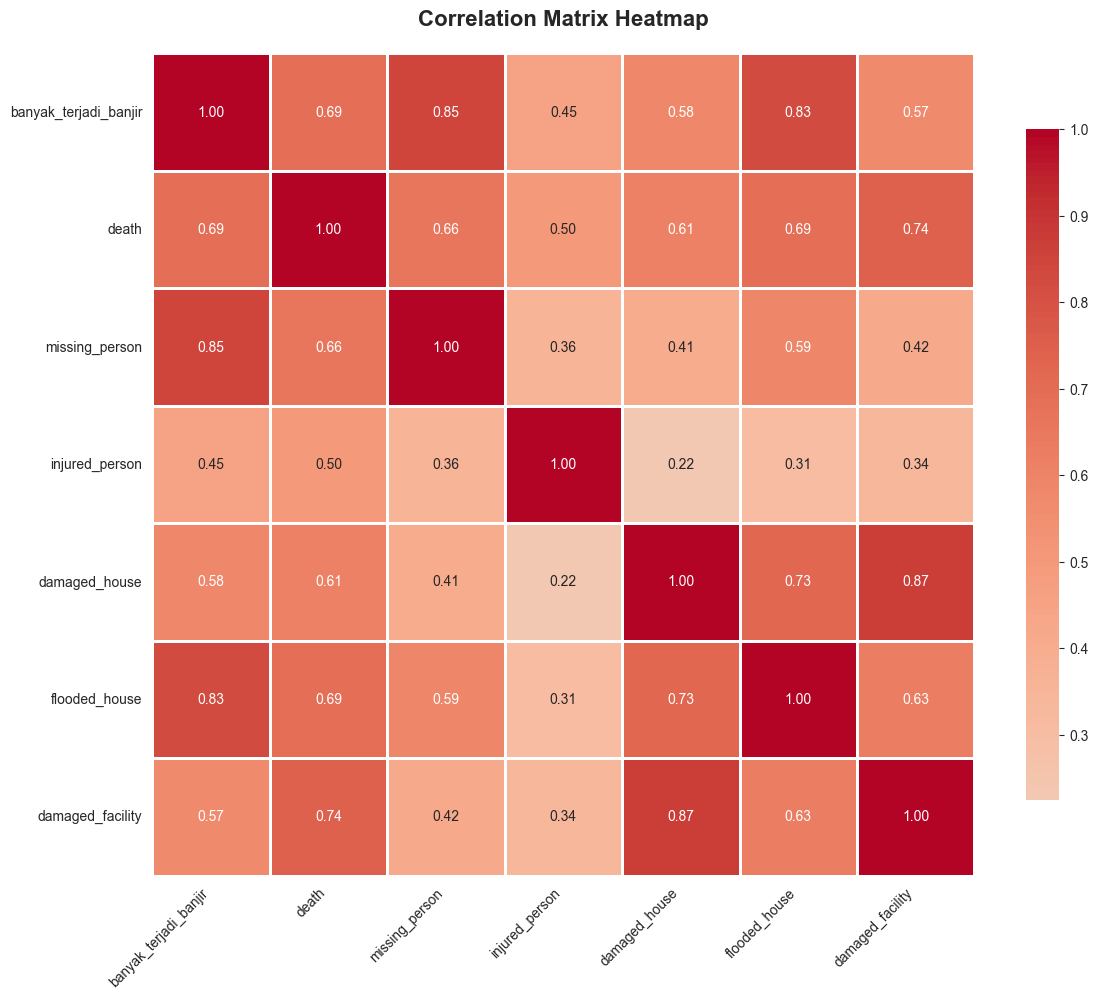


Pasangan Fitur dengan Korelasi Tinggi (|r| > 0.7):
            Feature 1        Feature 2  Correlation
banyak_terjadi_banjir   missing_person     0.850452
banyak_terjadi_banjir    flooded_house     0.826495
                death damaged_facility     0.744593
        damaged_house    flooded_house     0.727329
        damaged_house damaged_facility     0.872277


In [5]:
# Correlation Matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

# Visualisasi Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identifikasi korelasi tinggi (> 0.7 atau < -0.7)
print("\nPasangan Fitur dengan Korelasi Tinggi (|r| > 0.7):")
print("="*60)
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr)
    print(high_corr_df.to_string(index=False))
else:
    print("Tidak ada korelasi yang melebihi threshold 0.7")


VARIANCE INFLATION FACTOR (VIF)
                Fitur       VIF
banyak_terjadi_banjir 19.123233
        flooded_house 10.732512
     damaged_facility 10.348021
       missing_person  9.174104
        damaged_house  8.602805
                death  7.460564
       injured_person  1.776901

Interpretasi VIF:
  VIF = 1      : Tidak ada korelasi
  1 < VIF < 5  : Korelasi sedang
  5 < VIF < 10 : Korelasi tinggi
  VIF > 10     : Multikolinearitas serius


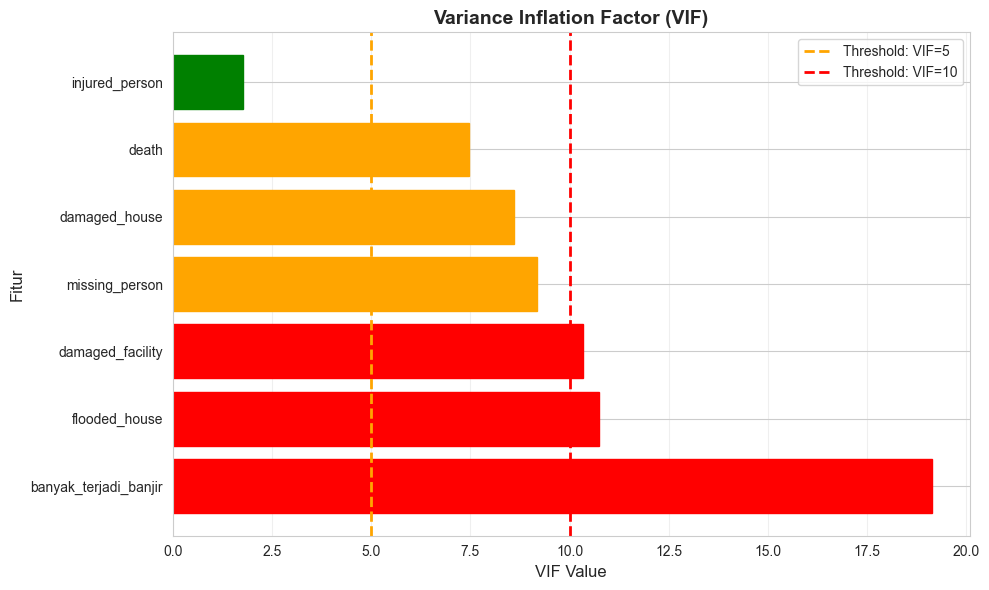

In [6]:
# Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Hitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data["Fitur"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(df[numeric_cols].values, i) 
                   for i in range(len(numeric_cols))]

# Sort berdasarkan VIF
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\n" + "="*60)
print("VARIANCE INFLATION FACTOR (VIF)")
print("="*60)
print(vif_data.to_string(index=False))
print("\n" + "="*60)
print("Interpretasi VIF:")
print("  VIF = 1      : Tidak ada korelasi")
print("  1 < VIF < 5  : Korelasi sedang")
print("  5 < VIF < 10 : Korelasi tinggi")
print("  VIF > 10     : Multikolinearitas serius")
print("="*60)

# Visualisasi VIF
plt.figure(figsize=(10, 6))
bars = plt.barh(vif_data['Fitur'], vif_data['VIF'], color='steelblue', edgecolor='black')

# Warnai bar berdasarkan threshold
for i, (bar, vif_val) in enumerate(zip(bars, vif_data['VIF'])):
    if vif_val > 10:
        bar.set_color('red')
    elif vif_val > 5:
        bar.set_color('orange')
    else:
        bar.set_color('green')

plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='Threshold: VIF=5')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Threshold: VIF=10')
plt.xlabel('VIF Value', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.title('Variance Inflation Factor (VIF)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Kesimpulan Analisis Multikolinearitas

**Temuan:**

1. **Korelasi Tinggi (> 0.7):**
   - `banyak_terjadi_banjir` ↔ `missing_person` (0.85)
   - `banyak_terjadi_banjir` ↔ `flooded_house` (0.83)
   - `damaged_house` ↔ `damaged_facility` (0.87)
   - `death` ↔ `damaged_facility` (0.74)
   - `damaged_house` ↔ `flooded_house` (0.73)

2. **VIF Sangat Tinggi (> 10):**
   - `banyak_terjadi_banjir`: VIF = 19.12 ⚠️
   - `flooded_house`: VIF = 10.73 ⚠️
   - `damaged_facility`: VIF = 10.35 ⚠️

**Implikasi:**
- Ada multikolinearitas yang cukup serius dalam data
- Fitur-fitur berkorelasi dapat mendominasi perhitungan jarak dalam clustering
- PCA sangat bermanfaat untuk mengatasi masalah ini

**Solusi yang Diterapkan:**
- **Standardisasi**: Menyamakan skala semua fitur
- **PCA**: Mentransformasi fitur yang berkorelasi menjadi komponen independen
- Clustering dilakukan pada data asli (untuk hasil yang komprehensif)
- Visualisasi menggunakan PCA (untuk reduksi multikolinearitas)

In [7]:
print("="*60)
print("REKOMENDASI PENANGANAN MULTIKOLINEARITAS")
print("="*60)
print("\nStrategi yang dapat diterapkan:")
print("\n1. TETAP GUNAKAN SEMUA FITUR (pilihan saat ini)")
print("   ✓ Informasi lengkap dari semua aspek banjir")
print("   ✓ Setiap fitur merepresentasikan aspek berbeda dari bencana")
print("   ✗ Multikolinearitas MASIH ADA (standardisasi TIDAK menghilangkan multikolinearitas)")
print("   ✗ Fitur berkorelasi dapat mendominasi perhitungan jarak")

print("\n2. HAPUS FITUR DENGAN VIF TINGGI")
print("   Hapus: banyak_terjadi_banjir, flooded_house, damaged_facility")
print("   Pertahankan: death, missing_person, injured_person, damaged_house")
print("   ✓ Mengurangi redundansi dan multikolinearitas")
print("   ✗ Kehilangan informasi penting")

print("\n3. CLUSTERING PADA KOMPONEN PCA")
print("   Gunakan komponen PCA sebagai input clustering")
print("   ✓ Menghilangkan multikolinearitas SEPENUHNYA")
print("   ✓ Komponen PCA saling INDEPENDEN (ortogonal)")
print("   ✓ Tidak ada korelasi antar komponen")
print("   ✗ Interpretasi lebih sulit (tidak ada fitur asli)")

print("\n4. FEATURE ENGINEERING")
print("   Buat fitur gabungan/rasio dari fitur yang berkorelasi")
print("   ✓ Mengurangi dimensi tanpa kehilangan informasi")
print("   ✗ Memerlukan domain knowledge")

print("\n" + "="*60)
print("KEPUTUSAN: Tetap menggunakan semua fitur dengan standardisasi")
print("="*60)
print("\nAlasan:")
print("- Setiap fitur merepresentasikan aspek berbeda dari bencana banjir")
print("- Standardisasi HANYA menyamakan skala (bukan menghilangkan korelasi)")
print("- Multikolinearitas masih ada, tapi diterima karena interpretasi penting")
print("- PCA untuk visualisasi membantu mengatasi multikolinearitas dalam plot")
print("- Untuk dataset kecil (38 provinsi), mempertahankan semua informasi penting")
print("\nCATATAN PENTING:")
print("⚠️  Standardisasi ≠ Menghilangkan Multikolinearitas")
print("✓  Standardisasi = Menyamakan skala fitur (mean=0, std=1)")
print("✓  PCA = Menghilangkan multikolinearitas (komponen ortogonal)")
print("="*60)

REKOMENDASI PENANGANAN MULTIKOLINEARITAS

Strategi yang dapat diterapkan:

1. TETAP GUNAKAN SEMUA FITUR (pilihan saat ini)
   ✓ Informasi lengkap dari semua aspek banjir
   ✓ Setiap fitur merepresentasikan aspek berbeda dari bencana
   ✗ Multikolinearitas MASIH ADA (standardisasi TIDAK menghilangkan multikolinearitas)
   ✗ Fitur berkorelasi dapat mendominasi perhitungan jarak

2. HAPUS FITUR DENGAN VIF TINGGI
   Hapus: banyak_terjadi_banjir, flooded_house, damaged_facility
   Pertahankan: death, missing_person, injured_person, damaged_house
   ✓ Mengurangi redundansi dan multikolinearitas
   ✗ Kehilangan informasi penting

3. CLUSTERING PADA KOMPONEN PCA
   Gunakan komponen PCA sebagai input clustering
   ✓ Menghilangkan multikolinearitas SEPENUHNYA
   ✓ Komponen PCA saling INDEPENDEN (ortogonal)
   ✓ Tidak ada korelasi antar komponen
   ✗ Interpretasi lebih sulit (tidak ada fitur asli)

4. FEATURE ENGINEERING
   Buat fitur gabungan/rasio dari fitur yang berkorelasi
   ✓ Mengurangi dim

### 2.2 Uji Kaiser-Meyer-Olkin (KMO)

KMO test digunakan untuk mengukur kecukupan sampling dan kesesuaian data untuk analisis faktor atau PCA. KMO mengukur seberapa besar proporsi varians dalam data yang disebabkan oleh faktor bersama.

**Interpretasi:**
- KMO ≥ 0.9: Sangat baik (marvelous)
- 0.8 ≤ KMO < 0.9: Baik (meritorious)
- 0.7 ≤ KMO < 0.8: Cukup (middling)
- 0.6 ≤ KMO < 0.7: Sedang (mediocre)
- 0.5 ≤ KMO < 0.6: Buruk (miserable)
- KMO < 0.5: Tidak dapat diterima (unacceptable)

In [8]:
from scipy.stats import chi2
import numpy as np

def calculate_kmo(data):
    """
    Calculate Kaiser-Meyer-Olkin (KMO) measure
    """
    # Korelasi matrix
    corr_matrix = data.corr().values
    
    # Inverse korelasi matrix
    corr_inv = np.linalg.inv(corr_matrix)
    
    # Partial correlation matrix
    partial_corr = np.zeros(corr_matrix.shape)
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            partial_corr[i, j] = -corr_inv[i, j] / np.sqrt(corr_inv[i, i] * corr_inv[j, j])
    
    # KMO calculation
    # Sum of squared correlations
    sum_corr_sq = np.sum(corr_matrix**2) - np.trace(corr_matrix**2)
    
    # Sum of squared partial correlations
    sum_partial_sq = np.sum(partial_corr**2) - np.trace(partial_corr**2)
    
    # Overall KMO
    kmo_num = sum_corr_sq
    kmo_denom = sum_corr_sq + sum_partial_sq
    kmo_overall = kmo_num / kmo_denom
    
    # Per-variable KMO
    kmo_per_variable = []
    for i in range(corr_matrix.shape[0]):
        num = np.sum(corr_matrix[i]**2) - corr_matrix[i, i]**2
        denom = num + np.sum(partial_corr[i]**2) - partial_corr[i, i]**2
        kmo_per_variable.append(num / denom if denom != 0 else 0)
    
    return kmo_overall, kmo_per_variable

# Hitung KMO
kmo_overall, kmo_per_var = calculate_kmo(df[numeric_cols])

print("\n" + "="*60)
print("KAISER-MEYER-OLKIN (KMO) TEST")
print("="*60)
print(f"\nOverall KMO Score: {kmo_overall:.4f}")

# Interpretasi
if kmo_overall >= 0.9:
    interpretation = "Sangat Baik (Marvelous) ✓"
elif kmo_overall >= 0.8:
    interpretation = "Baik (Meritorious) ✓"
elif kmo_overall >= 0.7:
    interpretation = "Cukup (Middling)"
elif kmo_overall >= 0.6:
    interpretation = "Sedang (Mediocre)"
elif kmo_overall >= 0.5:
    interpretation = "Buruk (Miserable)"
else:
    interpretation = "Tidak Dapat Diterima (Unacceptable) ✗"

print(f"Interpretasi: {interpretation}")
print("\n" + "="*60)
print("KMO Score per Fitur:")
print("="*60)

kmo_df = pd.DataFrame({
    'Fitur': numeric_cols,
    'KMO Score': kmo_per_var
}).sort_values('KMO Score', ascending=False)

print(kmo_df.to_string(index=False))
print("\n" + "="*60)
print("Kesimpulan:")
if kmo_overall >= 0.6:
    print("✓ Data COCOK untuk analisis faktor/PCA")
    print("✓ Variabel saling berkorelasi dengan baik")
else:
    print("✗ Data KURANG COCOK untuk analisis faktor/PCA")
    print("✗ Pertimbangkan untuk menghapus variabel dengan KMO rendah")
print("="*60)


KAISER-MEYER-OLKIN (KMO) TEST

Overall KMO Score: 0.6343
Interpretasi: Sedang (Mediocre)

KMO Score per Fitur:
                Fitur  KMO Score
       injured_person   0.684101
                death   0.666532
        damaged_house   0.660948
banyak_terjadi_banjir   0.632282
     damaged_facility   0.624786
        flooded_house   0.621554
       missing_person   0.581457

Kesimpulan:
✓ Data COCOK untuk analisis faktor/PCA
✓ Variabel saling berkorelasi dengan baik


## 3. Preprocessing Data

In [9]:
# Simpan nama provinsi
provinces = df.iloc[:, 0].values if df.shape[1] > 0 else df.index

# Pilih fitur numerik untuk clustering
# Asumsikan kolom pertama adalah nama provinsi, sisanya adalah fitur
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_features) == 0:
    # Jika tidak ada kolom numerik, convert semua kecuali kolom pertama
    feature_cols = df.columns[1:] if df.shape[1] > 1 else df.columns
    X = df[feature_cols].apply(pd.to_numeric, errors='coerce')
else:
    X = df[numeric_features].copy()

print(f"Jumlah fitur numerik: {X.shape[1]}")
print(f"Fitur yang digunakan: {list(X.columns)}")
print(f"\nShape data: {X.shape}")

Jumlah fitur numerik: 7
Fitur yang digunakan: ['banyak_terjadi_banjir', 'death', 'missing_person', 'injured_person', 'damaged_house', 'flooded_house', 'damaged_facility']

Shape data: (38, 7)


### Handle Missing Values

In [10]:
# Handle missing values
print("Handling missing values...")
X_filled = X.fillna(X.median())

# Standardisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

print(f"Data berhasil di-preprocessing!")
print(f"Shape setelah preprocessing: {X_scaled.shape}")

Handling missing values...
Data berhasil di-preprocessing!
Shape setelah preprocessing: (38, 7)


### PCA

In [11]:
# Reduksi dimensi untuk visualisasi (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variance dijelaskan oleh 2 komponen PCA: {pca.explained_variance_ratio_.sum():.2%}")

Variance dijelaskan oleh 2 komponen PCA: 78.53%


## 4. Menentukan Jumlah Cluster Optimal

Kita akan menggunakan **Elbow Method** dan **Silhouette Score** untuk menentukan jumlah cluster optimal.

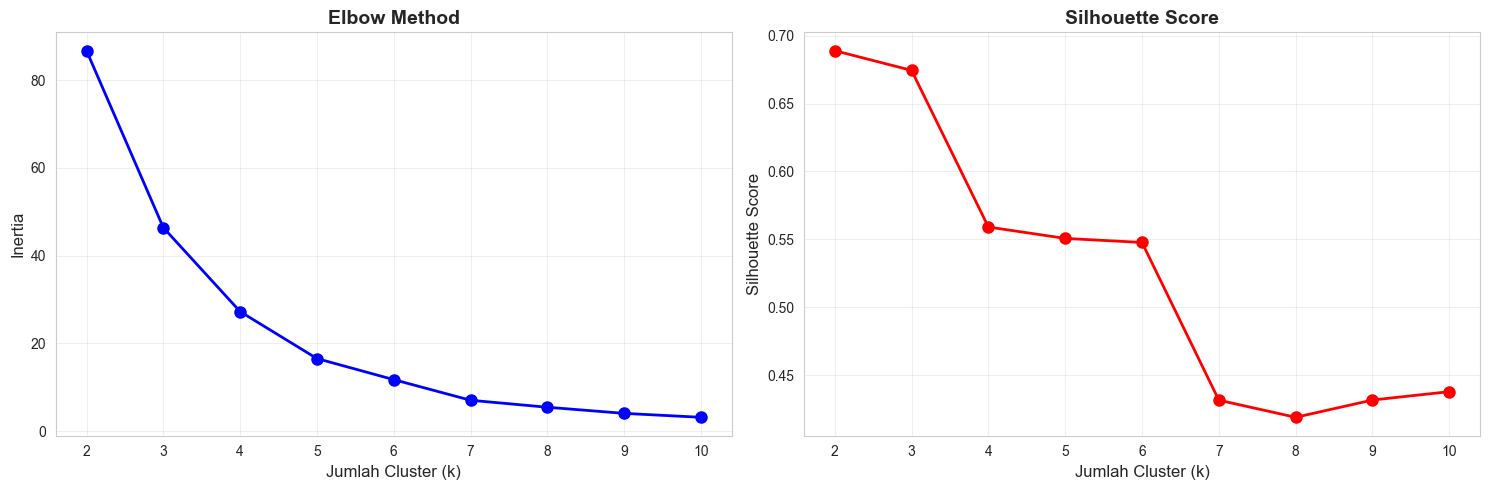


Jumlah cluster optimal berdasarkan Silhouette Score: 2
Silhouette Score terbaik: 0.6890


In [12]:
# Elbow Method dan Silhouette Score
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot Elbow Method
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Jumlah Cluster (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Jumlah Cluster (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Temukan k optimal berdasarkan silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nJumlah cluster optimal berdasarkan Silhouette Score: {optimal_k}")
print(f"Silhouette Score terbaik: {max(silhouette_scores):.4f}")

## 5. Clustering dengan KMeans

In [13]:
# KMeans Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

# Evaluasi
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
kmeans_db = davies_bouldin_score(X_pca, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X_pca, kmeans_labels)

print("="*60)
print("HASIL CLUSTERING KMEANS")
print("="*60)
print(f"Jumlah Cluster: {optimal_k}")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Index: {kmeans_db:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_ch:.4f}")
print("="*60)

HASIL CLUSTERING KMEANS
Jumlah Cluster: 2
Silhouette Score: 0.6890
Davies-Bouldin Index: 0.7447
Calinski-Harabasz Score: 50.7407


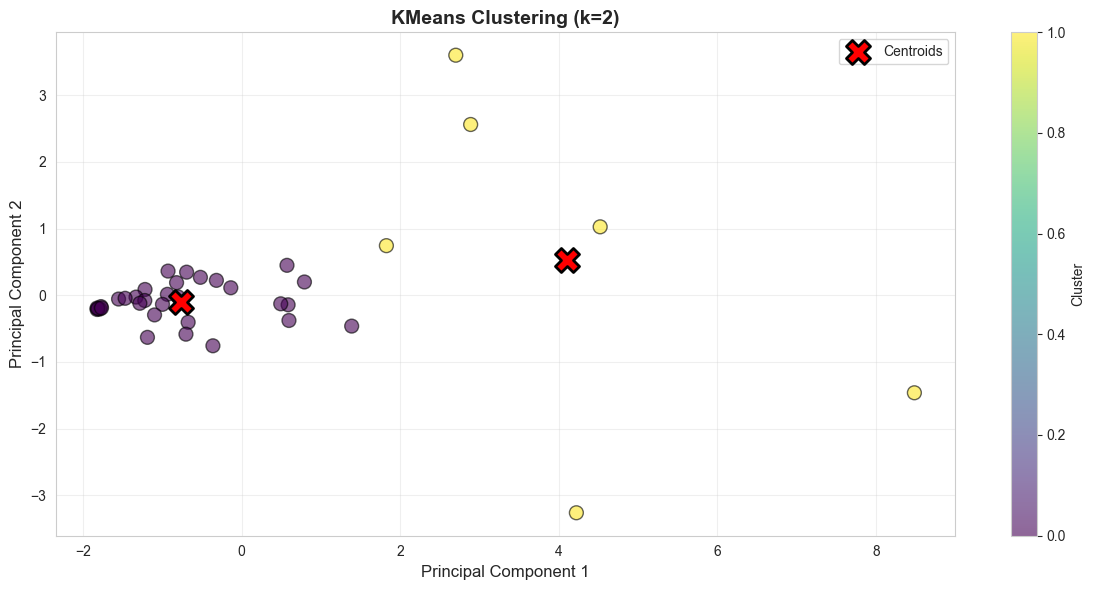

In [14]:
# Visualisasi KMeans
plt.figure(figsize=(12, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', linewidths=2,
           label='Centroids')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title(f'KMeans Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Clustering dengan GMM (Gaussian Mixture Model)

In [15]:
# GMM Clustering
gmm = GaussianMixture(n_components=optimal_k, random_state=42, covariance_type='full')
gmm_labels = gmm.fit_predict(X_pca)

# Evaluasi
gmm_silhouette = silhouette_score(X_pca, gmm_labels)
gmm_db = davies_bouldin_score(X_pca, gmm_labels)
gmm_ch = calinski_harabasz_score(X_pca, gmm_labels)

print("="*60)
print("HASIL CLUSTERING GMM")
print("="*60)
print(f"Jumlah Cluster: {optimal_k}")
print(f"Silhouette Score: {gmm_silhouette:.4f}")
print(f"Davies-Bouldin Index: {gmm_db:.4f}")
print(f"Calinski-Harabasz Score: {gmm_ch:.4f}")
print(f"BIC: {gmm.bic(X_pca):.2f}")
print(f"AIC: {gmm.aic(X_pca):.2f}")
print("="*60)

HASIL CLUSTERING GMM
Jumlah Cluster: 2
Silhouette Score: 0.6890
Davies-Bouldin Index: 0.7447
Calinski-Harabasz Score: 50.7407
BIC: 215.48
AIC: 197.47


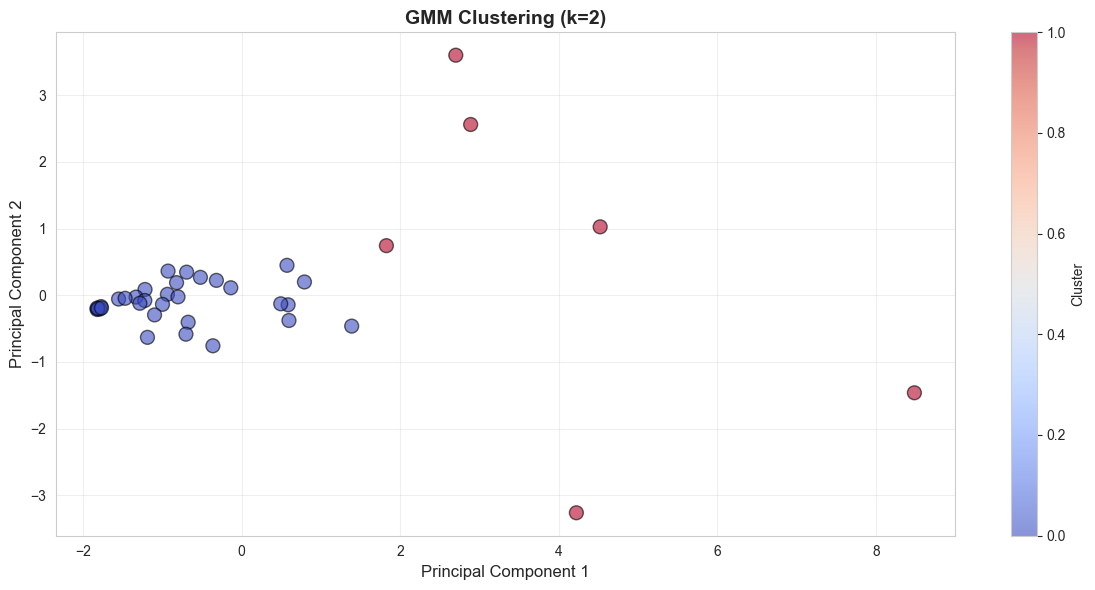

In [16]:
# Visualisasi GMM
plt.figure(figsize=(12, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, 
                     cmap='coolwarm', s=100, alpha=0.6, edgecolors='black')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title(f'GMM Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Clustering dengan DBSCAN

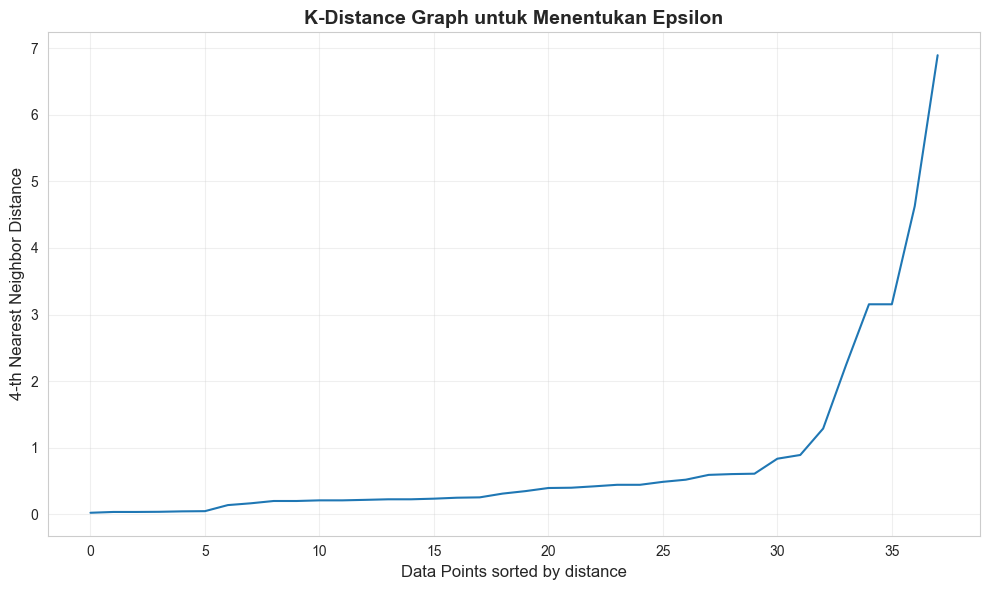


Epsilon optimal (estimasi): 2.515


In [17]:
# Mencari parameter optimal untuk DBSCAN menggunakan nearest neighbors
from sklearn.neighbors import NearestNeighbors

# Hitung k-nearest neighbors untuk menentukan eps
k = 4  # min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points sorted by distance', fontsize=12)
plt.ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph untuk Menentukan Epsilon', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gunakan knee/elbow dari grafik sebagai eps
# Bisa menggunakan percentile sebagai estimasi
eps_optimal = np.percentile(distances, 90)
print(f"\nEpsilon optimal (estimasi): {eps_optimal:.3f}")

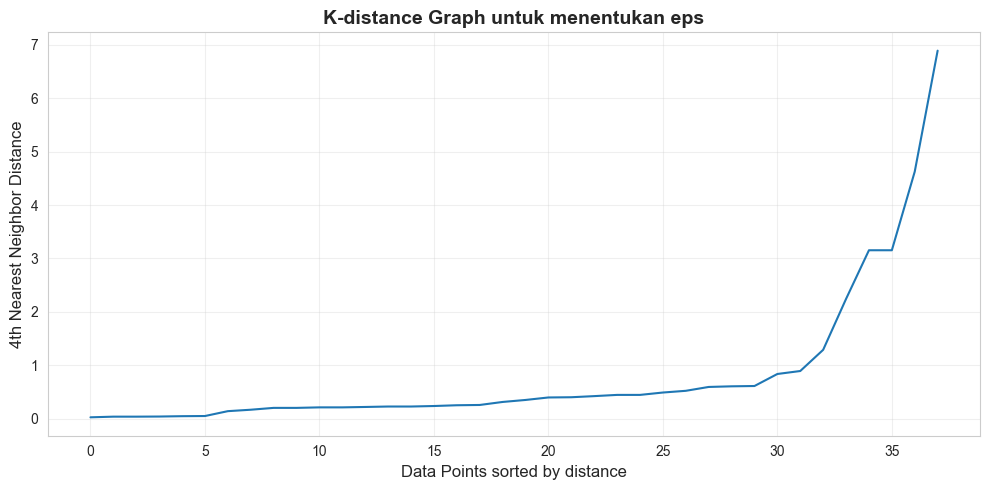

Estimasi eps optimal: 0.517


In [18]:
# Mencari parameter optimal untuk DBSCAN menggunakan nearest neighbors
from sklearn.neighbors import NearestNeighbors

# Hitung jarak ke k-nearest neighbors
k = 4  # min_samples = k + 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Plot untuk menentukan eps
distances_sorted = np.sort(distances[:, k-1], axis=0)
plt.figure(figsize=(10, 5))
plt.plot(distances_sorted)
plt.xlabel('Data Points sorted by distance', fontsize=12)
plt.ylabel('4th Nearest Neighbor Distance', fontsize=12)
plt.title('K-distance Graph untuk menentukan eps', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estimasi eps dari grafik - gunakan persentil lebih rendah untuk dataset kecil
eps_optimal = np.percentile(distances_sorted, 70)  # Turunkan dari 90 ke 70
print(f"Estimasi eps optimal: {eps_optimal:.3f}")

In [19]:
# DBSCAN Clustering - sesuaikan parameter untuk dataset kecil
dbscan = DBSCAN(eps=0.9, min_samples=2)  # Parameter lebih sensitif
dbscan_labels = dbscan.fit_predict(X_pca)

# Hitung jumlah cluster dan noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print("="*60)
print("HASIL CLUSTERING DBSCAN")
print("="*60)
print(f"Epsilon (eps): 0.9")
print(f"Min Samples: 2")
print(f"Jumlah Cluster: {n_clusters}")
print(f"Jumlah Noise Points: {n_noise}")

# Evaluasi (hanya jika ada lebih dari 1 cluster dan bukan semua noise)
if n_clusters > 1 and n_noise < len(dbscan_labels):
    # Filter out noise points untuk evaluasi
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        dbscan_silhouette = silhouette_score(X_pca[mask], dbscan_labels[mask])
        dbscan_db = davies_bouldin_score(X_pca[mask], dbscan_labels[mask])
        dbscan_ch = calinski_harabasz_score(X_pca[mask], dbscan_labels[mask])
        print(f"Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"Davies-Bouldin Index: {dbscan_db:.4f}")
        print(f"Calinski-Harabasz Score: {dbscan_ch:.4f}")
    else:
        print("Tidak dapat menghitung metrik evaluasi (semua data adalah noise)")
        dbscan_silhouette = dbscan_db = dbscan_ch = np.nan
else:
    print("Tidak dapat menghitung metrik evaluasi (cluster tidak mencukupi)")
    dbscan_silhouette = dbscan_db = dbscan_ch = np.nan

print("="*60)

HASIL CLUSTERING DBSCAN
Epsilon (eps): 0.9
Min Samples: 2
Jumlah Cluster: 1
Jumlah Noise Points: 6
Tidak dapat menghitung metrik evaluasi (cluster tidak mencukupi)


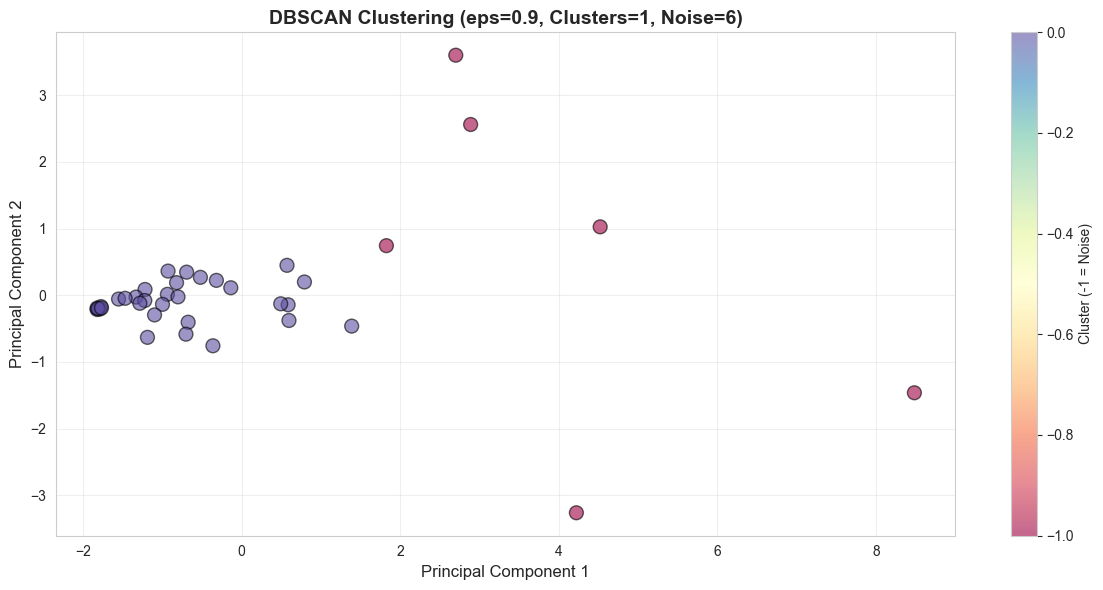

In [20]:
# Visualisasi DBSCAN
plt.figure(figsize=(12, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, 
                     cmap='Spectral', s=100, alpha=0.6, edgecolors='black')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title(f'DBSCAN Clustering (eps=0.9, Clusters={n_clusters}, Noise={n_noise})', 
         fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster (-1 = Noise)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Perbandingan Semua Metode Clustering

In [21]:
# Tabel perbandingan metrik evaluasi
comparison_data = {
    'Metode': ['KMeans', 'GMM', 'DBSCAN'],
    'Jumlah Cluster': [optimal_k, optimal_k, n_clusters],
    'Silhouette Score': [kmeans_silhouette, gmm_silhouette, dbscan_silhouette],
    'Davies-Bouldin Index': [kmeans_db, gmm_db, dbscan_db],
    'Calinski-Harabasz Score': [kmeans_ch, gmm_ch, dbscan_ch]
}

comparison_df = pd.DataFrame(comparison_data)
print("="*80)
print("PERBANDINGAN METRIK EVALUASI CLUSTERING")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)
print("\nCatatan:")
print("- Silhouette Score: Semakin tinggi semakin baik (range: -1 to 1)")
print("- Davies-Bouldin Index: Semakin rendah semakin baik")
print("- Calinski-Harabasz Score: Semakin tinggi semakin baik")

PERBANDINGAN METRIK EVALUASI CLUSTERING
Metode  Jumlah Cluster  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score
KMeans               2          0.688954              0.744737                50.740675
   GMM               2          0.688954              0.744737                50.740675
DBSCAN               1               NaN                   NaN                      NaN

Catatan:
- Silhouette Score: Semakin tinggi semakin baik (range: -1 to 1)
- Davies-Bouldin Index: Semakin rendah semakin baik
- Calinski-Harabasz Score: Semakin tinggi semakin baik


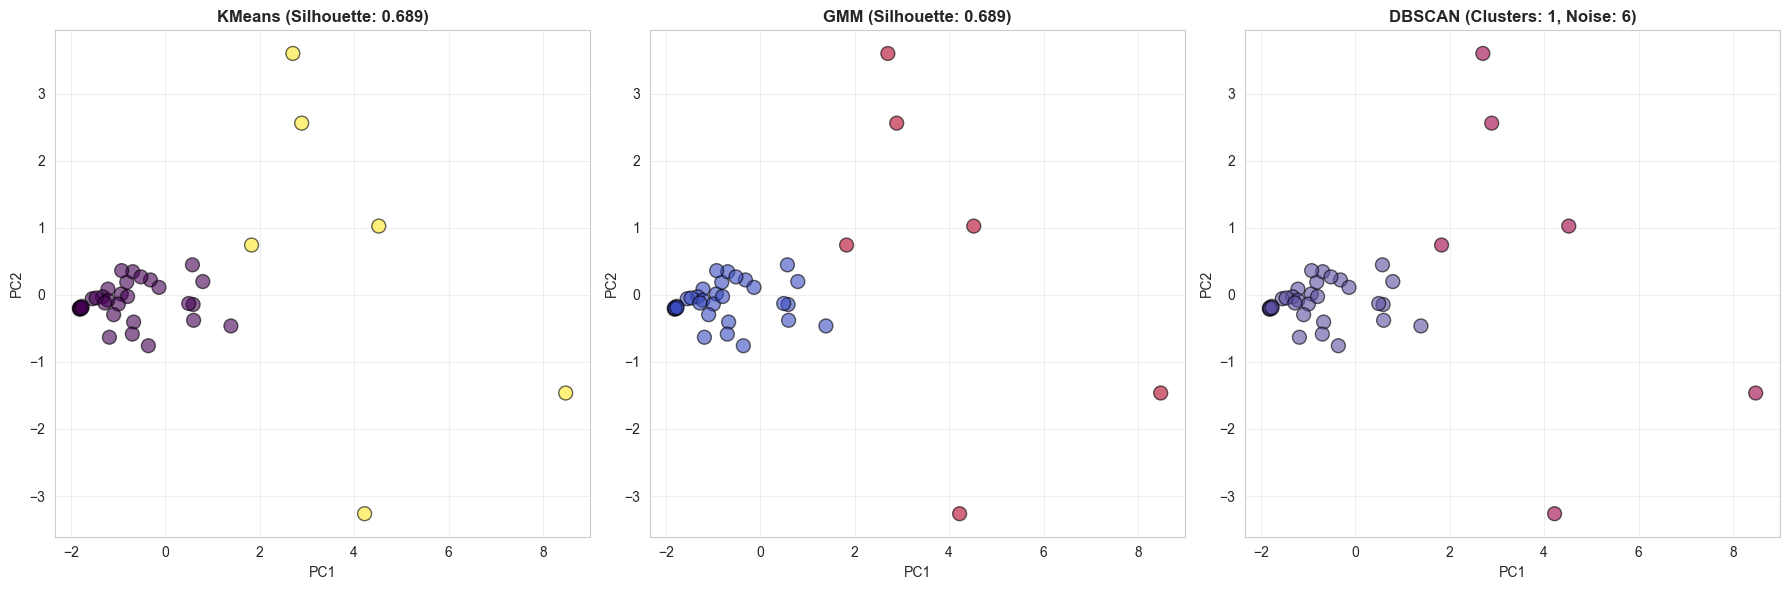

In [22]:
# Visualisasi perbandingan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# KMeans
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                           cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[0].set_title(f'KMeans (Silhouette: {kmeans_silhouette:.3f})', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True, alpha=0.3)

# GMM
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, 
                           cmap='coolwarm', s=100, alpha=0.6, edgecolors='black')
axes[1].set_title(f'GMM (Silhouette: {gmm_silhouette:.3f})', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(True, alpha=0.3)

# DBSCAN
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, 
                           cmap='Spectral', s=100, alpha=0.6, edgecolors='black')
if not np.isnan(dbscan_silhouette):
    axes[2].set_title(f'DBSCAN (Silhouette: {dbscan_silhouette:.3f}, Clusters: {n_clusters})', 
                      fontsize=12, fontweight='bold')
else:
    axes[2].set_title(f'DBSCAN (Clusters: {n_clusters}, Noise: {n_noise})', 
                      fontsize=12, fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

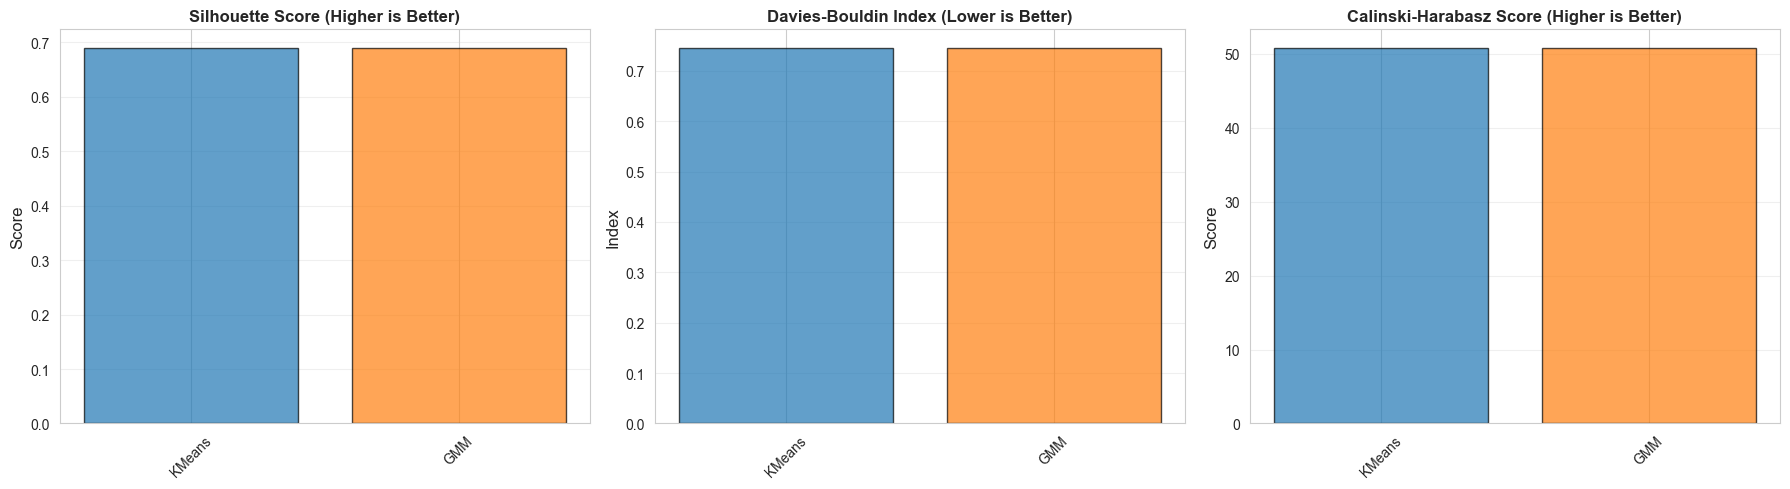

In [23]:
# Visualisasi bar chart perbandingan metrik
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = comparison_df['Metode'].tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Silhouette Score
axes[0].bar(methods, comparison_df['Silhouette Score'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Davies-Bouldin Index
axes[1].bar(methods, comparison_df['Davies-Bouldin Index'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Index', fontsize=12)
axes[1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# Calinski-Harabasz Score
axes[2].bar(methods, comparison_df['Calinski-Harabasz Score'], color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Score', fontsize=12)
axes[2].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 10. Kesimpulan dan Rekomendasi

### Analisis Hasil

Berdasarkan evaluasi menggunakan tiga metrik utama (Silhouette Score, Davies-Bouldin Index, dan Calinski-Harabasz Score), berikut adalah analisis perbandingan keempat metode clustering:

In [24]:
# Tentukan metode terbaik berdasarkan Silhouette Score
valid_scores = comparison_df[comparison_df['Silhouette Score'].notna()]
if len(valid_scores) > 0:
    best_method_idx = valid_scores['Silhouette Score'].idxmax()
    best_method = comparison_df.loc[best_method_idx, 'Metode']
    best_silhouette = comparison_df.loc[best_method_idx, 'Silhouette Score']
    
    print("="*80)
    print("REKOMENDASI METODE TERBAIK")
    print("="*80)
    print(f"\nMetode Terbaik: {best_method}")
    print(f"Silhouette Score: {best_silhouette:.4f}")
    print(f"\nAlasan:")
    print(f"- Memiliki Silhouette Score tertinggi ({best_silhouette:.4f})")
    print(f"- Davies-Bouldin Index: {comparison_df.loc[best_method_idx, 'Davies-Bouldin Index']:.4f}")
    print(f"- Calinski-Harabasz Score: {comparison_df.loc[best_method_idx, 'Calinski-Harabasz Score']:.4f}")
    print("\n" + "="*80)
    
    # Karakteristik setiap metode
    print("\nKARAKTERISTIK SETIAP METODE:")
    print("="*80)
    print("\n1. KMeans:")
    print("   - Cepat dan efisien untuk dataset besar")
    print("   - Sensitif terhadap outlier")
    print("   - Mengasumsikan cluster berbentuk spherical")
    
    print("\n2. GMM (Gaussian Mixture Model):")
    print("   - Model probabilistik, memberikan soft clustering")
    print("   - Dapat menangani cluster dengan bentuk dan ukuran berbeda")
    print("   - Lebih fleksibel dalam memodelkan distribusi data")
    
    print("\n3. DBSCAN:")
    print("   - Dapat menemukan cluster dengan bentuk arbitrary")
    print("   - Dapat mendeteksi outlier sebagai noise")
    print("   - Tidak perlu menentukan jumlah cluster di awal")
    print("   - Sensitif terhadap parameter eps dan min_samples")
    print("="*80)

REKOMENDASI METODE TERBAIK

Metode Terbaik: KMeans
Silhouette Score: 0.6890

Alasan:
- Memiliki Silhouette Score tertinggi (0.6890)
- Davies-Bouldin Index: 0.7447
- Calinski-Harabasz Score: 50.7407


KARAKTERISTIK SETIAP METODE:

1. KMeans:
   - Cepat dan efisien untuk dataset besar
   - Sensitif terhadap outlier
   - Mengasumsikan cluster berbentuk spherical

2. GMM (Gaussian Mixture Model):
   - Model probabilistik, memberikan soft clustering
   - Dapat menangani cluster dengan bentuk dan ukuran berbeda
   - Lebih fleksibel dalam memodelkan distribusi data

3. DBSCAN:
   - Dapat menemukan cluster dengan bentuk arbitrary
   - Dapat mendeteksi outlier sebagai noise
   - Tidak perlu menentukan jumlah cluster di awal
   - Sensitif terhadap parameter eps dan min_samples
